# Mundo - Projeção de Óbitos
> Projeção do número de óbitos por Covid no mundo.

- toc: false
- branch: master
- badges: false
- comments: true
- author: João Coelho
- categories: [coronavirus]

In [1]:
#hide
!wget https://opendata.ecdc.europa.eu/covid19/casedistribution/csv -O covid.csv

--2020-06-07 23:50:36--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
Resolving opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)... 212.181.0.63
Connecting to opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)|212.181.0.63|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/ [following]
--2020-06-07 23:50:36--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/
Reusing existing connection to opendata.ecdc.europa.eu:443.
HTTP request sent, awaiting response... 200 OK
Length: 1282919 (1.2M) [application/octet-stream]
Saving to: ‘covid.csv’

covid.csv           100%[===================>]   1.22M  2.74MB/s    in 0.4s    

2020-06-07 23:50:37 (2.74 MB/s) - ‘covid.csv’ saved [1282919/1282919]



In [0]:
#hide
import csv
import numpy as np
with open('covid.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  all_data = np.array([ row for row in csv_reader ])

In [0]:
#hide
def get_data(country, start=0, column='deaths'):
  if country=="World":
    c_data = all_data[1:]
  elif country=="World w/o China":
    c_data = all_data[all_data[:,6]!='China'][1:]
  elif country in np.unique(all_data[1:,6]):
    c_data = all_data[all_data[:,6]==country]
  elif country in np.unique(all_data[1:,-1]):
    c_data = all_data[all_data[:,-1]==country]
  else:
    return np.empty((0,2))

  column = {'deaths': 5, 'cases': 4}[column]

  for col in range(3):
    c_data = c_data[c_data[:,1+col].astype(int).argsort(kind='stable')]

  divs = np.sort(np.unique(c_data[:,0], return_index=True)[1])
  c_data = [ np.sum(c_data[c_data[:,0]==date][:,column].astype(int)) for date in c_data[divs,0] ]

  c_data = np.array([ np.sum(c_data[:i+1]) for i in range(len(c_data)) ])
  if c_data[-1] < start: return np.empty((0,2))
  prev = c_data[c_data<=start][-1]
  c_data = c_data[c_data>start]
  if len(c_data)<1: return c_data
  t0 = float(start-prev) / (c_data[0]-prev)

  c_data = np.transpose([np.arange(len(c_data))+1-t0, c_data])
  c_data = np.insert(c_data, 0, [0, start]).reshape((-1,2))

  return c_data

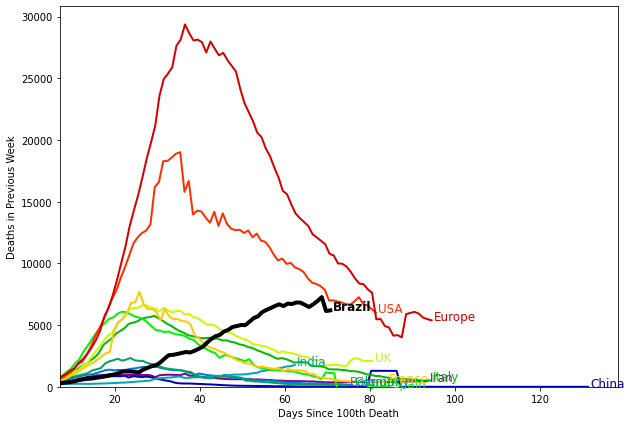

In [6]:
#hide
import matplotlib.pyplot as plt

my_countries = ["China", "South_Korea", "Japan", "Singapore", "Europe", "Brazil", \
"Italy", "Spain", "United_Kingdom", "United_States_of_America", "Germany", \
"Portugal", "Iran", "France", "Iraq", "India", "Belgium"]

from matplotlib import cm
cmap = cm.get_cmap('nipy_spectral')

replacements = {"United_States_of_America": "USA",
                "United_Kingdom": "UK",
                "South_Korea": "S. Korea",
                "_": " "}

plot_data = []
for country in my_countries:
  x,y = np.transpose(get_data(country, start=100))
  if len(x)<8: continue
  y = y[7:] - y[:-7]
  x = x[7:]
  for i,o in replacements.items():
    country = country.replace(i, o)
  ymax = np.max(y)
  if ymax<500: continue
  if country=="Brazil": ymax *= 1e6
  plot_data.append([x,y,country,ymax])

plot_data = np.array(plot_data)
plt.figure(figsize=(10,7))
for k,data in enumerate(plot_data[plot_data[:,-1].argsort()]):
  x,y = data[:2]
  color = cmap((k+1)/len(plot_data))
  width = 2
  weight = 'normal'
  if data[2]=="Brazil":
    color = 'k'
    width = 4
    weight = 'bold'
  plt.plot(x,y, color=color, linewidth=width)
  plt.text(x[-1]+0.6,y[-1],data[2], color=color, fontweight=weight, fontsize=12)
x = np.arange(1e2,2e3)
xmax = np.max(np.concatenate(plot_data[:,0]))
ymax = np.max(np.concatenate(plot_data[:,1]))
plt.gca().set_aspect('auto')
plt.xlim(7,xmax+7)
plt.ylim(0,1.05*ymax)
plt.ylabel('Deaths in Previous Week')
plt.xlabel('Days Since 100th Death')
plt.show()

O gráfico mostra a taxa de crescimento no número de óbitos em cada país ou região em função do total de óbitos em escala logarítmica. A taxa de crescimento é estimada como a média geométrica do crescimento observado num período de 7 dias. 

Observa-se uma relação quase linear com a taxa de crescimento desacelerando em função do tempo. Esse comportamento é consistente com um modelo de Gompertz.

Baseado nesse ansatz, fazemos uma projeção linear para estimar o número total de óbitos até o fim da epidemia. O declive da reta de projeção é estimado a partir da média mundial e é mantido fixo.

Esse modelo é extremamente simplificado e não tem uma base teórica bem fundamentada. O intuito é meramente indicar uma tendência para progressão da epidemia em cada país.

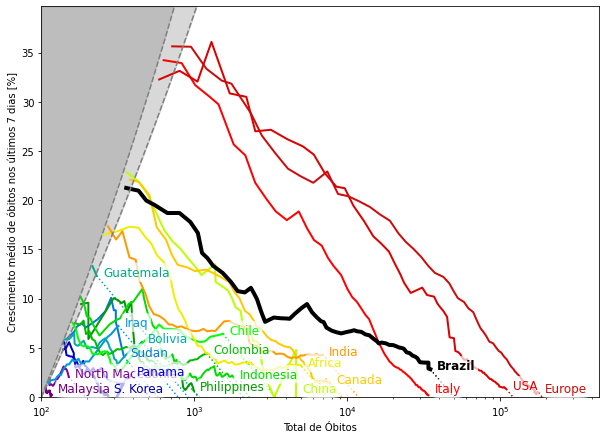

In [7]:
#hide_input
import matplotlib.pyplot as plt

def get_rate(country, lag=7, start=10):
  c_data = get_data(country, start=start, column='deaths')
  if len(c_data)<lag: return np.empty((0,2))
  x = c_data[lag:,1]
  y = 100*((c_data[lag:,1]/c_data[:-lag,1])**(1/(c_data[lag:,0]-c_data[:-lag,0])) - 1)
  return np.transpose([x,y])

def get_population(country):
  if country in np.unique(all_data[1:,7]):
    selection = all_data[all_data[:,7]==country]
    uniq = np.unique(selection[:,-1], return_index=True)[1]
    return np.sum(selection[uniq,-2].astype(int))
  elif country in np.unique(all_data[1:,-1]):
    return all_data[all_data[:,-1]==country][0,-2].astype(int)
  else: return 0

my_countries = ["China", "South_Korea", "Singapore", "Europe", "Brazil",
                "Italy", "United_States_of_America","Africa", "India"]

from matplotlib import cm
cmap = cm.get_cmap('nipy_spectral')

replacements = {"United_States_of_America": "USA",
                "United_Kingdom": "UK",
                "South_Korea": "S. Korea",
                "Saudi_Arabia": "S. Arabia",
                "_": " "}

val_data = []
my_lag = 7
my_start = 100
relative = False
for country in np.unique(np.concatenate([np.unique(all_data[1:,[6,-1]]), my_countries])):
  x,y = np.transpose(get_rate(country, start=my_start, lag=my_lag))
  if len(x)<2: continue
  if relative: x /= get_population(country)
  pred = 10**(y[-1]/18.5)*x[-1]
  scol = y[-1]
  if country in my_countries: scol *= 1e6
  if country=="Brazil": scol *= 1e6
  val_data.append([x,y,country,pred,scol])

def near_sel(pred, gr):
  for s in selected:
    if np.log(pred/s[0])**2/np.log(2.1)**2 < 1  and (gr-s[1])**2/1.5**2 < 1: return True
  return False

val_data = np.array(val_data)
val_data = val_data[val_data[:,-1].argsort()]
plot_data = []
selected = []
for data in val_data[::-1]:
  country = data[2]
  pred = data[-2]
  if country not in my_countries and near_sel(pred, data[1][-1]):
    continue
  selected.append([pred,data[1][-1]])
  data[-1] = pred
  if country=="Brazil": data[-1] *= 1e6
  for i,o in replacements.items():
    data[2] = data[2].replace(i, o)
  plot_data.append(data)

plot_data = np.array(plot_data)
plt.figure(figsize=(10,10))
for k,data in enumerate(plot_data[plot_data[:,-1].argsort()]):
  x,y = data[:2]
  color = cmap((k+1)/len(plot_data))
  width = 2
  weight = 'normal'
  if data[2]=="Brazil":
    color = 'k'
    width = 4
    weight = 'bold'
  plt.plot(x,y, color=color, linewidth=width)
  plt.plot([x[-1],data[-2]],[y[-1],0], color=color, linestyle='dotted')
  plt.text(1.1*x[-1],np.max([y[-1],0.5]),data[2],
           color=color, fontweight=weight, fontsize=12,
           bbox=dict(boxstyle="round4", fc=(1,1,1,0.7), ec=(1,1,1,0)))

xmax = 2.5*np.max(np.concatenate(plot_data[:,0]))
ymax = 1.1*np.max(np.concatenate(plot_data[:,1]))

if relative:
  xmin = np.min(np.concatenate(plot_data[:,0]))
  plt.xlabel('Total Deaths / Population')
else:
  xmin = my_start
  x = my_start*(ymax/100+1)**(my_lag*np.arange(0, 1.1, 0.1))
  plt.plot(x,100*((x/my_start)**(1/my_lag) - 1), color='gray', linestyle='--')
  plt.plot(x,100*((x/my_start)**(1/(my_lag-1)) - 1), color='gray', linestyle='--')
  plt.fill_between(x,[ymax]*len(x),100*((x/my_start)**(1/my_lag) - 1), color='gray', alpha=0.3)
  plt.fill_between(x,[ymax]*len(x),100*((x/my_start)**(1/(my_lag-1)) - 1), color='gray', alpha=0.3)
  plt.xlabel('Total de Óbitos')

plt.xlim(xmin, xmax)
plt.gca().set_aspect(0.7*np.log10(xmax/xmin)/ymax)
plt.ylim(0,ymax)
plt.xscale('log')
plt.ylabel(f'Crescimento médio de óbitos nos últimos {my_lag} dias [%]')
plt.show()